# Clinical Data Analysis with Machine Learning
## Introduction

This notebook explores an advanced analysis of clinical data using machine learning techniques. The aim is to extract meaningful insights from clinical datasets to predict patient outcomes, stratify patients based on disease severity, and visualize data dimensions for better understanding.

## Data Preprocessing

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

clinical_df = pd.read_csv('data/clinical.tsv', sep='\t')
clinical_df['vital_status'] = np.where(clinical_df['days_to_death'].isna() | (clinical_df['days_to_death'] == "'--"), 1, 0)
conditions = [
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*3),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*3) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*5),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*5) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*10),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*10) & (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) < 365*20),
    (clinical_df['days_to_death'].replace("'--", np.NaN).apply(pd.to_numeric) >= 365*20),
    (clinical_df['days_to_death'] == "'--") | (clinical_df['days_to_death'].isna())
]
values = [0, 1, 2, 3, 4, 5, 6]
clinical_df['status_strat'] = np.select(conditions, values)
clinical_df['vital_status'] = np.where(clinical_df['days_to_death'].isna() | (clinical_df['days_to_death'] == "'--"), 1, 0)
clinical_df['stage_m_strat'] = clinical_df['ajcc_clinical_m']
clinical_df['stage_m_strat'] = clinical_df['ajcc_pathologic_m'].map({'M0' : 0, 'MX' : 1})
clinical_df['stage_n_strat'] = clinical_df['ajcc_clinical_n'].replace("'--", np.NaN).map({'NX' : 0, 'N0' : 1, 'N1' : 2, 'N2' : 3, 'N2a' : 3, 'N2b' : 3, 'N2c' : 3, 'N3' : 4})
clinical_df['stage_strat'] = clinical_df['ajcc_clinical_stage'].replace("'--", np.NaN).map({'Stage I' : 0, 'Stage II' : 1, 'Stage III' : 2, 'Stage IVA' : 3, 'Stage IVB' : 3, 'Stage IVC' : 3})
clinical_df['stage_t_strat'] = clinical_df['ajcc_clinical_t'].replace("'--", np.NaN).map({'TX' : 0, 'T0' : 1, 'T1' : 2, 'T2' : 3, 'T3' : 4, 'T4' : 5, 'T4a' : 5, 'T4b' : 5})
clinical_df['diag_strat'] = clinical_df['morphology'].replace("'--", np.NaN).map({'8070/3' : 0, '8071/3' : 1, '8072/3' : 2, '8074/3' : 3, '8083/3' : 4})

clinical_df = clinical_df[list(set(clinical_df.columns) & set(['case_submitter_id','vital_status', 'status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']))]

file_to_case_df = pd.read_csv('data/new_file_to_case.tsv', sep='\t')

df_s1 = pd.read_csv('data/new_rnaseq_s1.tsv', sep='\t')
df_s2 = pd.read_csv('data/new_rnaseq_s2.tsv', sep='\t')
df_s1_s2 = pd.read_csv('data/new_rnaseq_s1_s2.tsv', sep='\t')

data_frames = [df_s1, df_s2, df_s1_s2]
data_frame_names = ['S1', 'S2', 'S1_S2']

Initial steps include importing necessary libraries and loading clinical data along with RNA sequencing data. We preprocess this data to include relevant features for our analysis, focusing on patient status, stage stratifications, and diagnostic stratifications.

## Feature Engineering and Model Evaluation

### Classification

In [8]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Assuming clinical_df, file_to_case_df, df_s1, df_s2, and df_s1_s2 are already loaded and preprocessed

data_frames = [df_s1, df_s2, df_s1_s2]
data_frame_names = ['S1', 'S2', 'S1_S2']
targets = ['vital_status', 'status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']

for df_index, df in enumerate(data_frames):
    df_merged = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df_merged = pd.merge(df_merged, clinical_df, on='case_submitter_id', how='left')
    df_final = df_merged.drop(columns=['file_id', 'case_submitter_id'])

    for target in targets:
        df1 = pd.concat([df_final.iloc[:, :-7], df_final[target]], axis=1).dropna()
        X = df1.iloc[:, :-1]
        y = df1.iloc[:, -1]
        X = MinMaxScaler().fit_transform(X)

        # Cross-validation scores
        print(f"{target} in {data_frame_names[df_index]} dataset")
        scores = cross_val_score(RandomForestClassifier(), X, y, cv=6, scoring='f1_micro')
        print("Cross-validation scores:", scores)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
        classifier = RandomForestClassifier(random_state=42)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        print("F1 score (micro):", f1_score(y_test, y_pred, average='micro'))


vital_status in S1 dataset
Cross-validation scores: [0.5862069  0.63218391 0.62068966 0.52325581 0.58139535 0.58139535]
F1 score (micro): 0.5769230769230769
status_strat in S1 dataset


c:\Users\Hsiun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(


Cross-validation scores: [0.59770115 0.56321839 0.52873563 0.56976744 0.54651163 0.55813953]
F1 score (micro): 0.5961538461538461
stage_m_strat in S1 dataset
Cross-validation scores: [0.76190476 0.68292683 0.75609756 0.7804878  0.75609756 0.75609756]
F1 score (micro): 0.68
stage_n_strat in S1 dataset
Cross-validation scores: [0.52325581 0.48837209 0.41860465 0.48837209 0.44186047 0.56470588]
F1 score (micro): 0.5192307692307693
stage_strat in S1 dataset
Cross-validation scores: [0.51764706 0.57142857 0.54761905 0.54761905 0.5952381  0.53571429]
F1 score (micro): 0.5098039215686274
stage_t_strat in S1 dataset
Cross-validation scores: [0.31395349 0.37209302 0.25581395 0.34883721 0.37209302 0.32941176]
F1 score (micro): 0.4423076923076923
diag_strat in S1 dataset


c:\Users\Hsiun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


Cross-validation scores: [0.85057471 0.85057471 0.85057471 0.86046512 0.84883721 0.86046512]
F1 score (micro): 0.8269230769230769
vital_status in S2 dataset
Cross-validation scores: [0.59770115 0.6091954  0.64367816 0.61627907 0.58139535 0.52325581]
F1 score (micro): 0.5769230769230769
status_strat in S2 dataset


c:\Users\Hsiun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(


Cross-validation scores: [0.56321839 0.55172414 0.55172414 0.58139535 0.55813953 0.54651163]
F1 score (micro): 0.6153846153846154
stage_m_strat in S2 dataset
Cross-validation scores: [0.71428571 0.73170732 0.7804878  0.73170732 0.75609756 0.7804878 ]
F1 score (micro): 0.72
stage_n_strat in S2 dataset
Cross-validation scores: [0.5        0.51162791 0.41860465 0.51162791 0.43023256 0.43529412]
F1 score (micro): 0.5769230769230769
stage_strat in S2 dataset
Cross-validation scores: [0.56470588 0.57142857 0.55952381 0.51190476 0.53571429 0.5       ]
F1 score (micro): 0.47058823529411764
stage_t_strat in S2 dataset
Cross-validation scores: [0.3255814  0.3372093  0.3255814  0.22093023 0.34883721 0.27058824]
F1 score (micro): 0.36538461538461536
diag_strat in S2 dataset


c:\Users\Hsiun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


Cross-validation scores: [0.85057471 0.85057471 0.85057471 0.84883721 0.84883721 0.84883721]
F1 score (micro): 0.8269230769230769
vital_status in S1_S2 dataset
Cross-validation scores: [0.57471264 0.63218391 0.62068966 0.54651163 0.60465116 0.54651163]
F1 score (micro): 0.5192307692307693
status_strat in S1_S2 dataset


c:\Users\Hsiun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=6.
  warnings.warn(


Cross-validation scores: [0.56321839 0.57471264 0.56321839 0.56976744 0.5        0.59302326]
F1 score (micro): 0.6153846153846154
stage_m_strat in S1_S2 dataset
Cross-validation scores: [0.78571429 0.70731707 0.7804878  0.7804878  0.75609756 0.7804878 ]
F1 score (micro): 0.68
stage_n_strat in S1_S2 dataset
Cross-validation scores: [0.5        0.47674419 0.44186047 0.52325581 0.48837209 0.55294118]
F1 score (micro): 0.5961538461538461
stage_strat in S1_S2 dataset
Cross-validation scores: [0.55294118 0.53571429 0.53571429 0.52380952 0.52380952 0.53571429]
F1 score (micro): 0.5686274509803921
stage_t_strat in S1_S2 dataset
Cross-validation scores: [0.31395349 0.36046512 0.34883721 0.31395349 0.39534884 0.34117647]
F1 score (micro): 0.38461538461538464
diag_strat in S1_S2 dataset


c:\Users\Hsiun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=6.
  warnings.warn(


Cross-validation scores: [0.85057471 0.85057471 0.85057471 0.86046512 0.84883721 0.86046512]
F1 score (micro): 0.8269230769230769


In this section, we merge RNA sequencing data with clinical data, focusing on various targets for prediction. We use RandomForestClassifier for our machine learning model and evaluate its performance using cross-validation and F1 scores.

### Dimensionality Reduction with PCA

#### Visualization of Latent Spaces across Datasets and Targets

PCA is applied to the merged datasets to reduce dimensionality, allowing us to visualize the data in two dimensions. This visualization helps in understanding the distribution of data points across different targets.

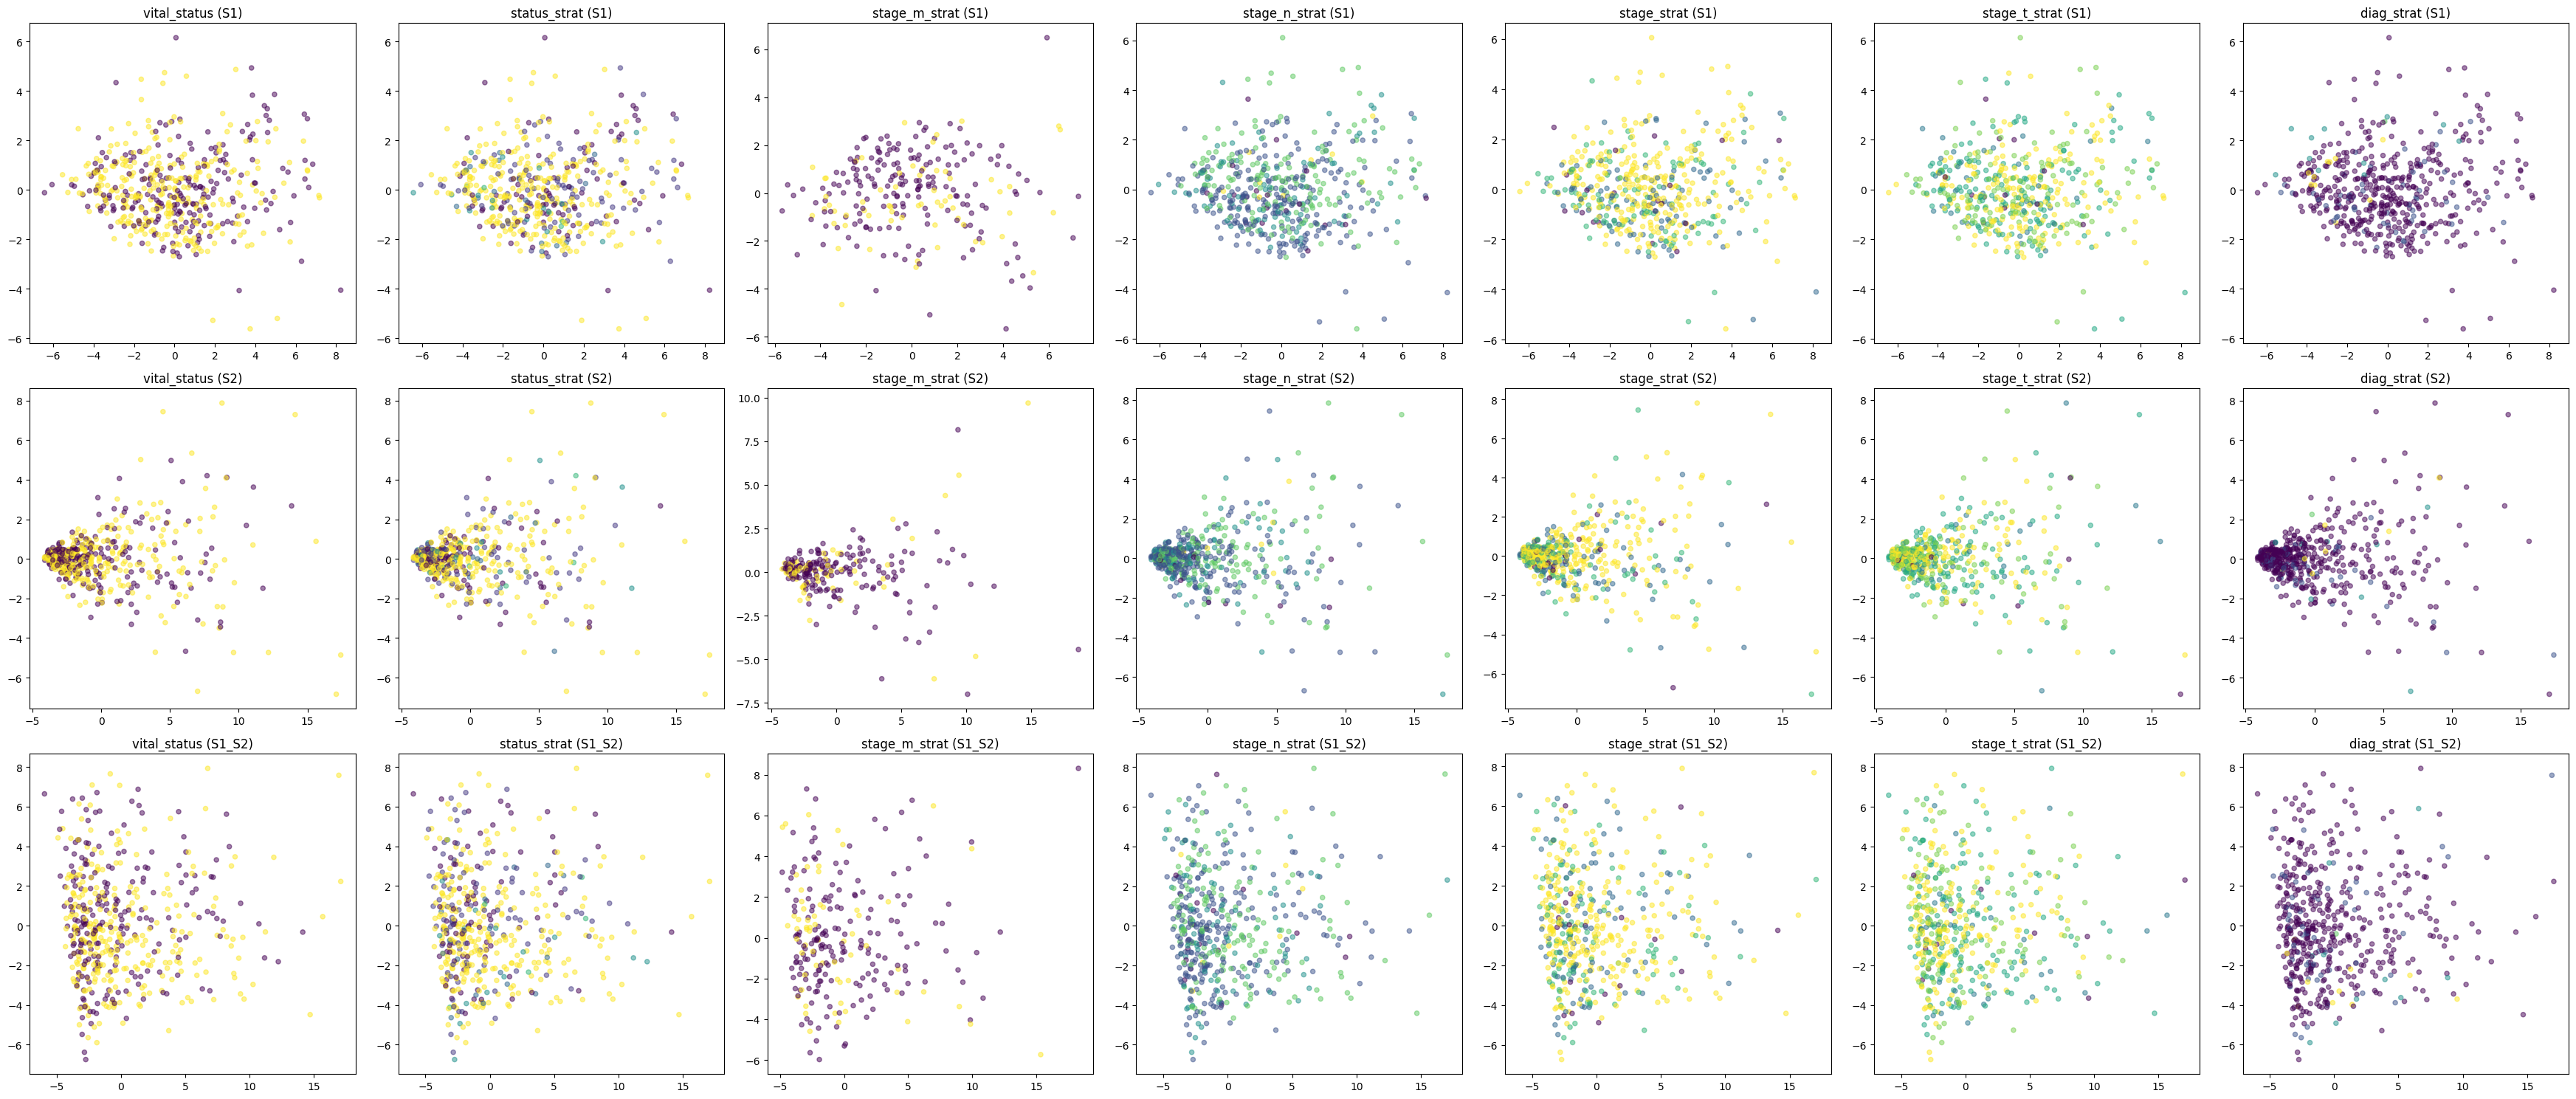

In [9]:
from sklearn.decomposition import PCA

targets = ['vital_status', 'status_strat', 'stage_m_strat', 'stage_n_strat', 'stage_strat', 'stage_t_strat', 'diag_strat']

plt.figure(figsize=(35, 15))

for df_index, df in enumerate(data_frames):
    df_merged = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df_merged = pd.merge(df_merged, clinical_df, on='case_submitter_id', how='left')
    df_final = df_merged.drop(columns=['file_id', 'case_submitter_id'])

    for i, target in enumerate(targets):
        df1 = pd.concat([df_final.iloc[:, :-7], df_final[target]], axis=1).dropna()
        X = df1.iloc[:, :-1]
        y = df1.iloc[:, -1]
        X = MinMaxScaler().fit_transform(X)

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(X_scaled)
        principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

        plt.subplot(3, 7, df_index * 7 + i + 1)
        plt.title(f"{target} ({data_frame_names[df_index]})")
        plt.scatter(principal_df['PC1'], principal_df['PC2'], c=y, cmap='viridis', s=20, alpha=0.5)

plt.tight_layout()
plt.show()

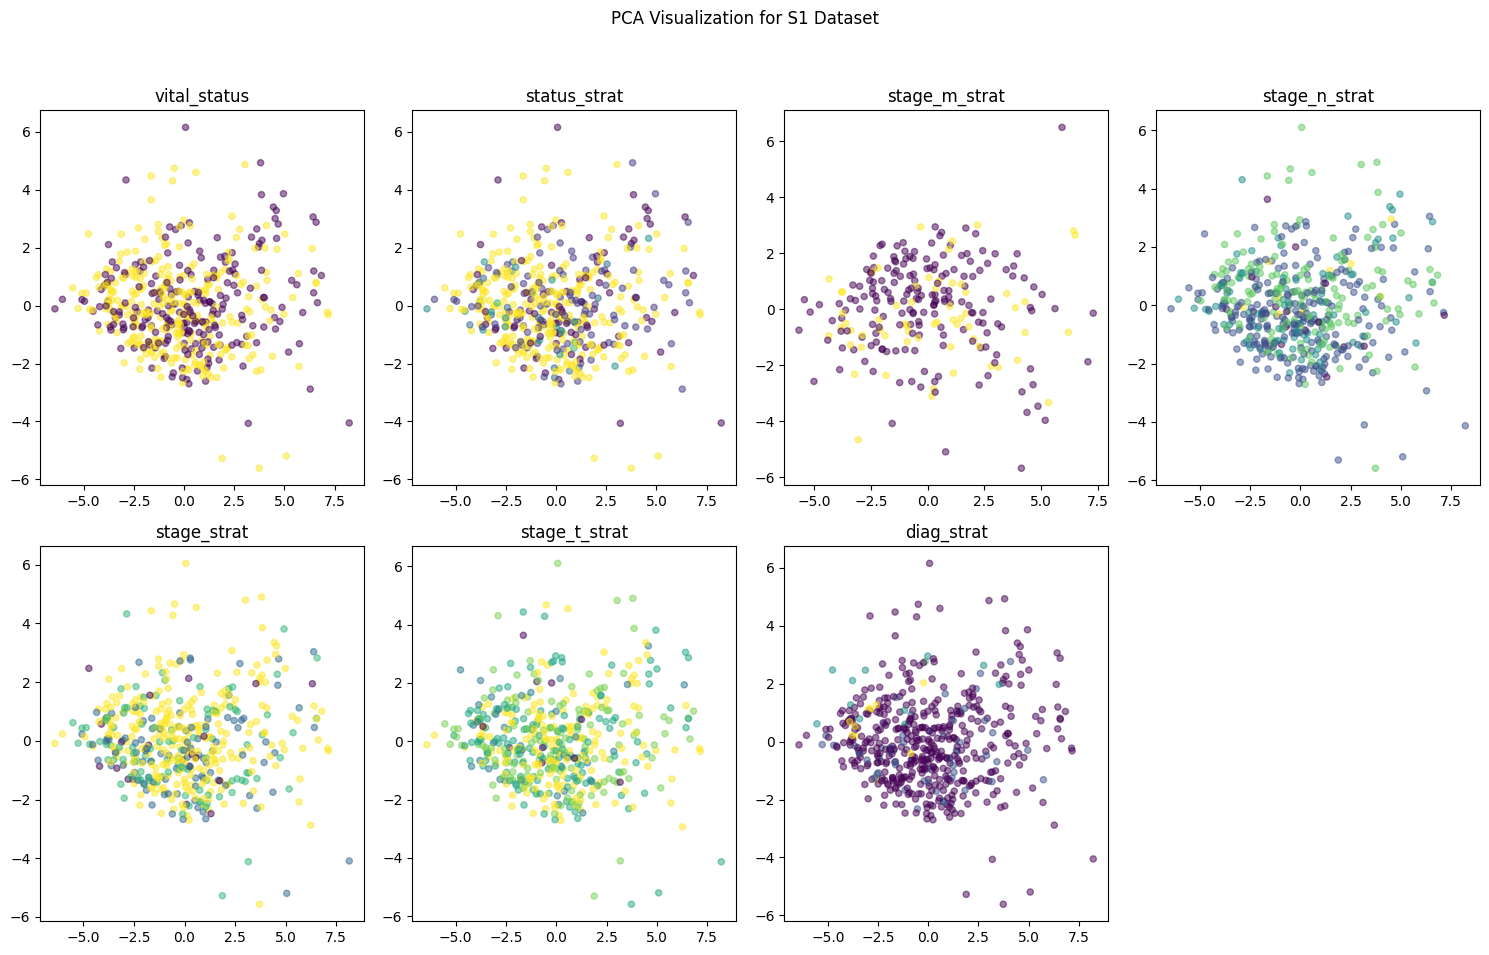

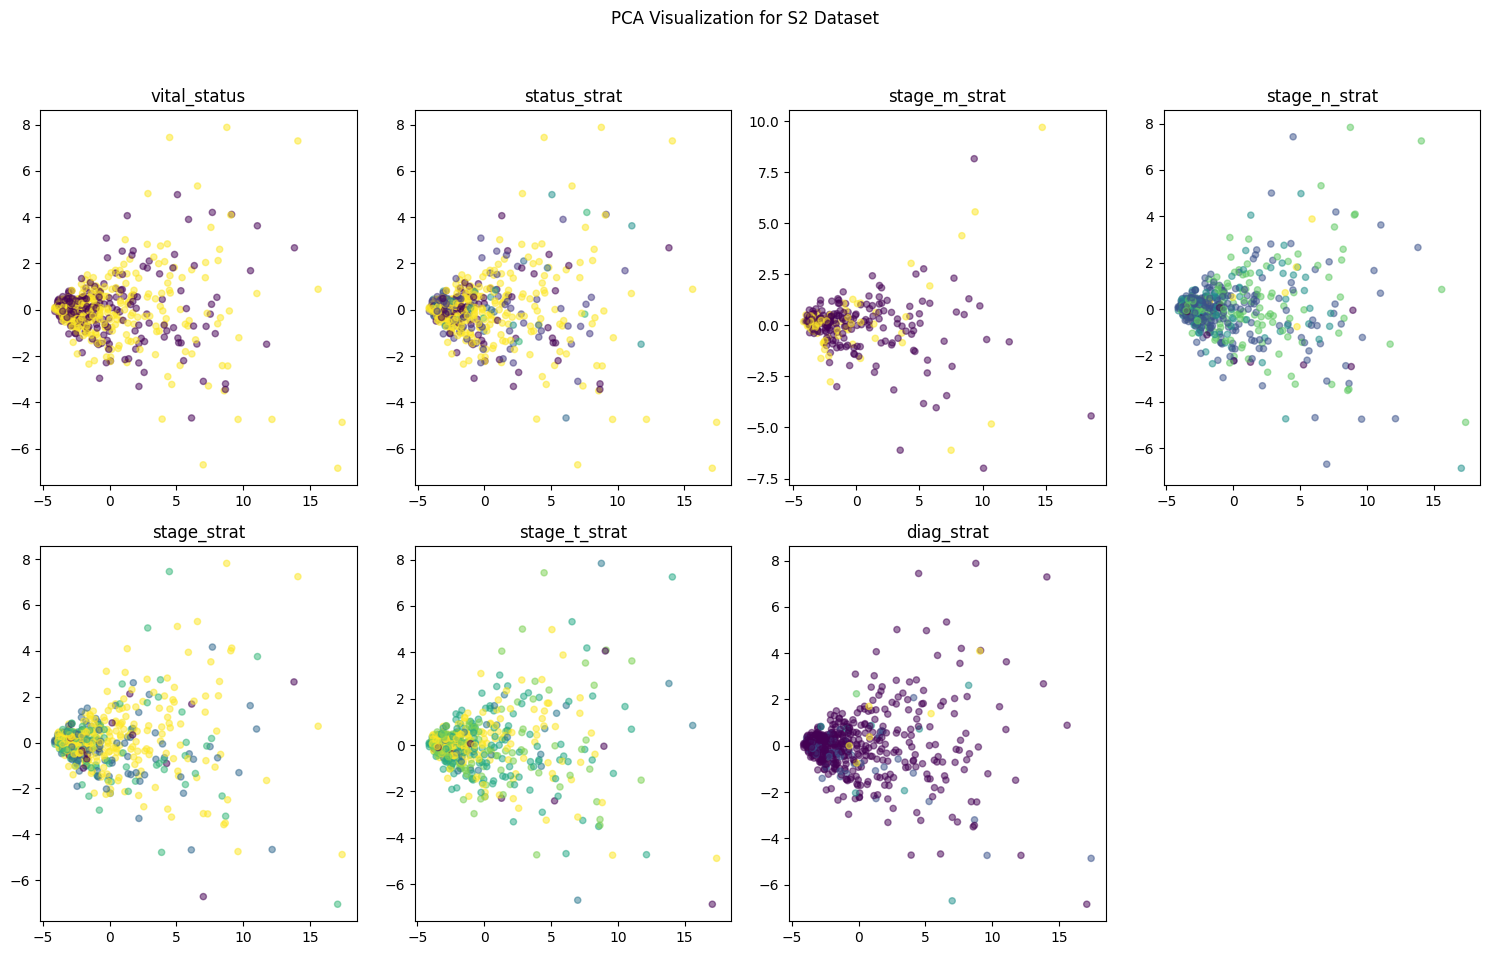

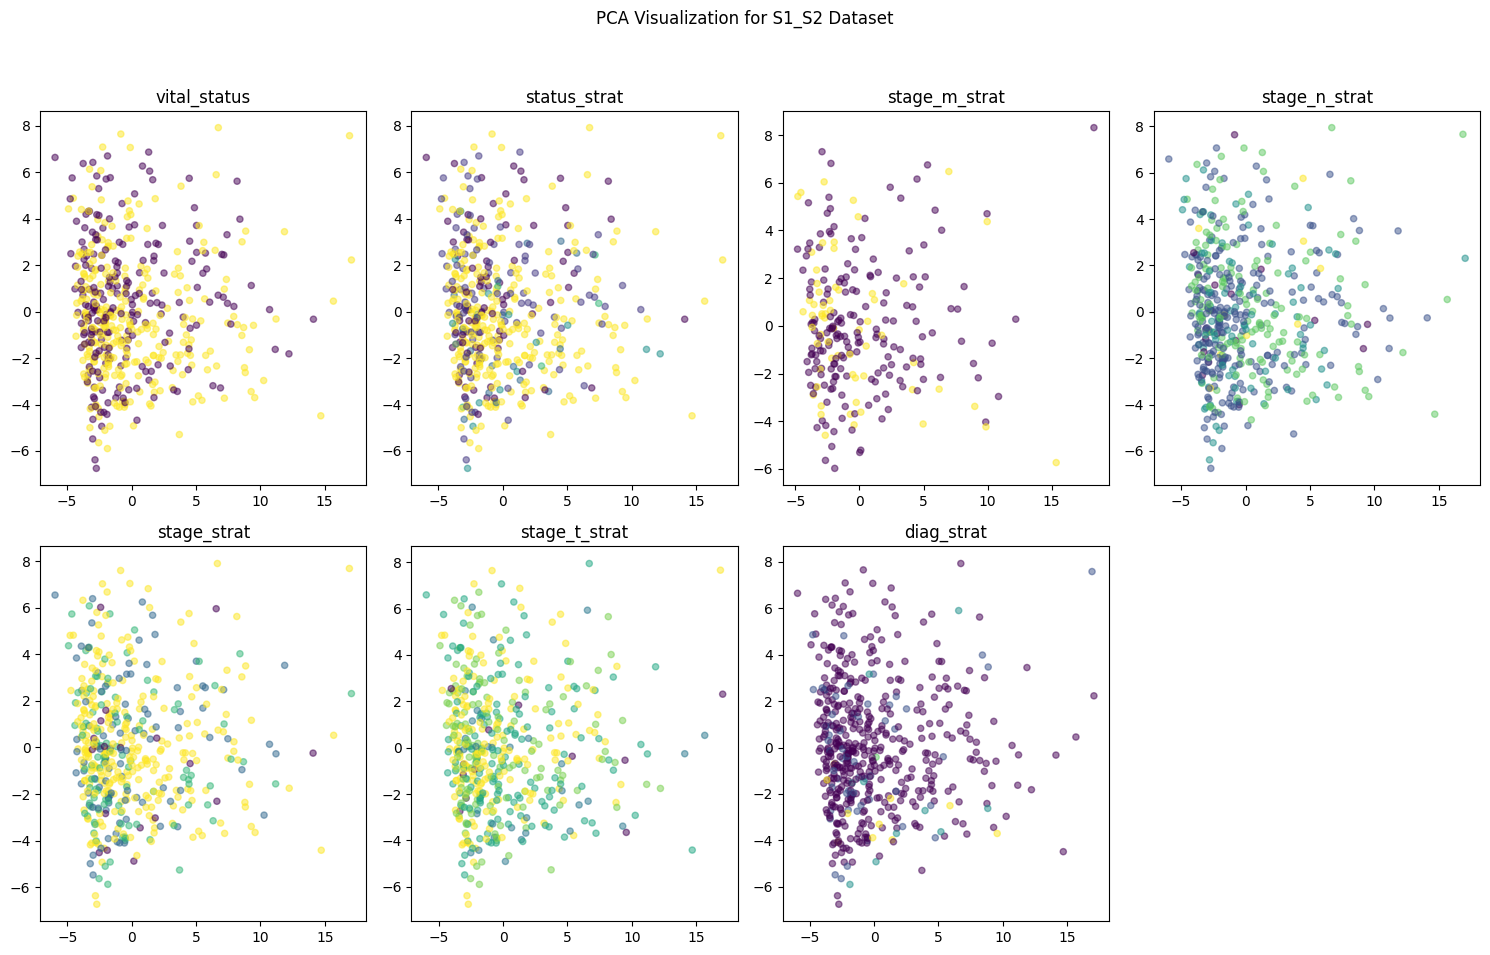

In [10]:
for df_index, df in enumerate(data_frames):
    df_merged = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df_merged = pd.merge(df_merged, clinical_df, on='case_submitter_id', how='left')
    df_final = df_merged.drop(columns=['file_id', 'case_submitter_id'])

    plt.figure(figsize=(15, 10))
    plt.suptitle(f"PCA Visualization for {data_frame_names[df_index]} Dataset")

    for i, target in enumerate(targets):
        df1 = pd.concat([df_final.iloc[:, :-7], df_final[target]], axis=1).dropna()
        X = df1.iloc[:, :-1]
        y = df1.iloc[:, -1]
        
        X_scaled = StandardScaler().fit_transform(X)
        principal_components = PCA(n_components=2).fit_transform(X_scaled)
        principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
        
        plt.subplot(2, 4, i + 1) 
        plt.title(target)
        plt.scatter(principal_df['PC1'], principal_df['PC2'], c=y, cmap='viridis', s=20, alpha=0.5)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()


## Autoencoder

### Training Autoencoders with Varied Neuron Counts

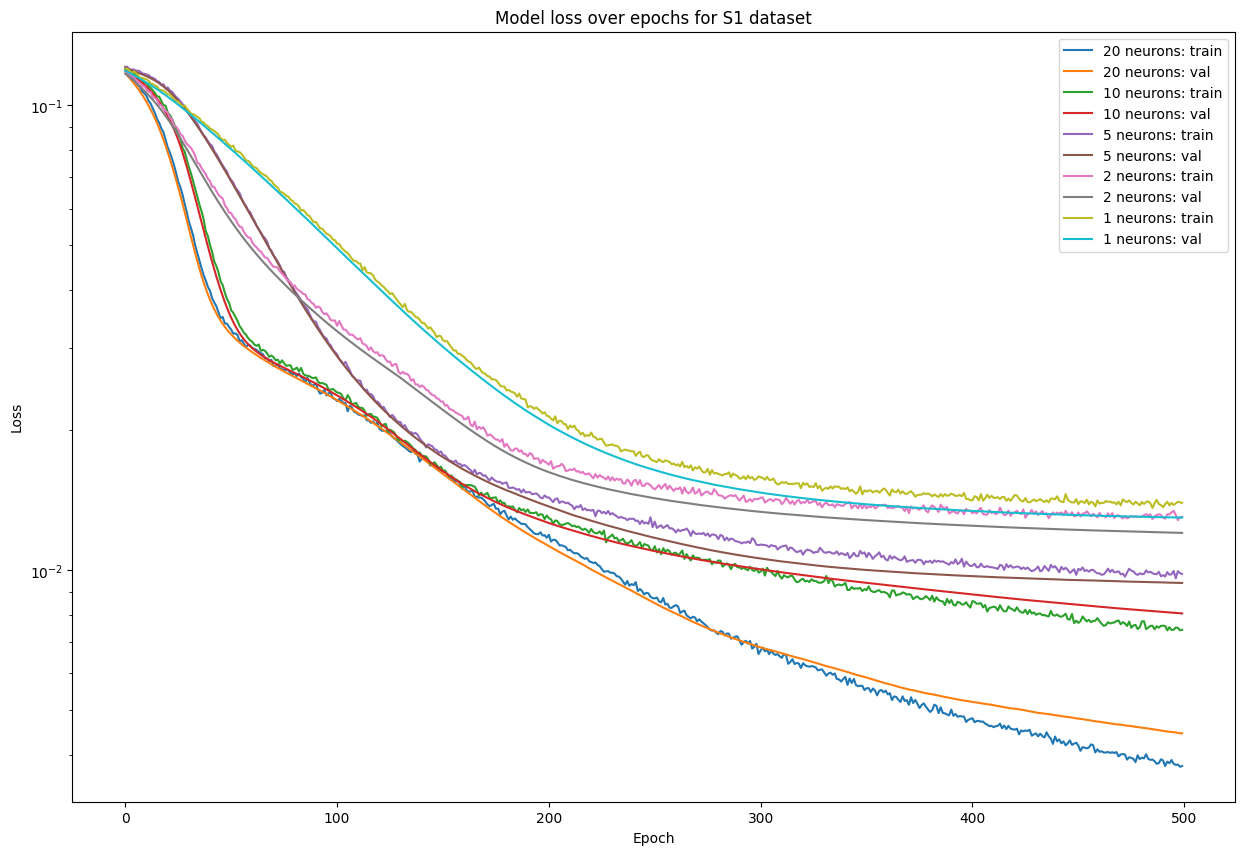

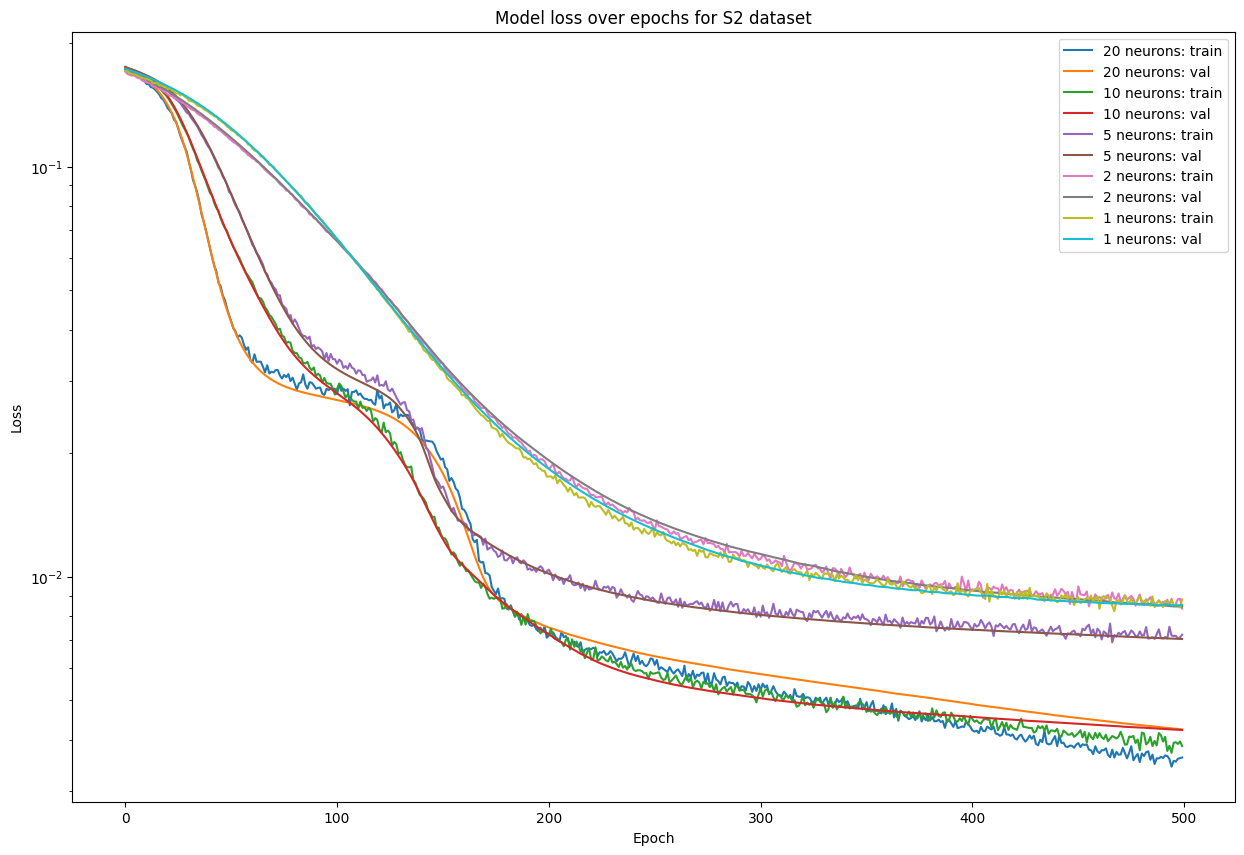

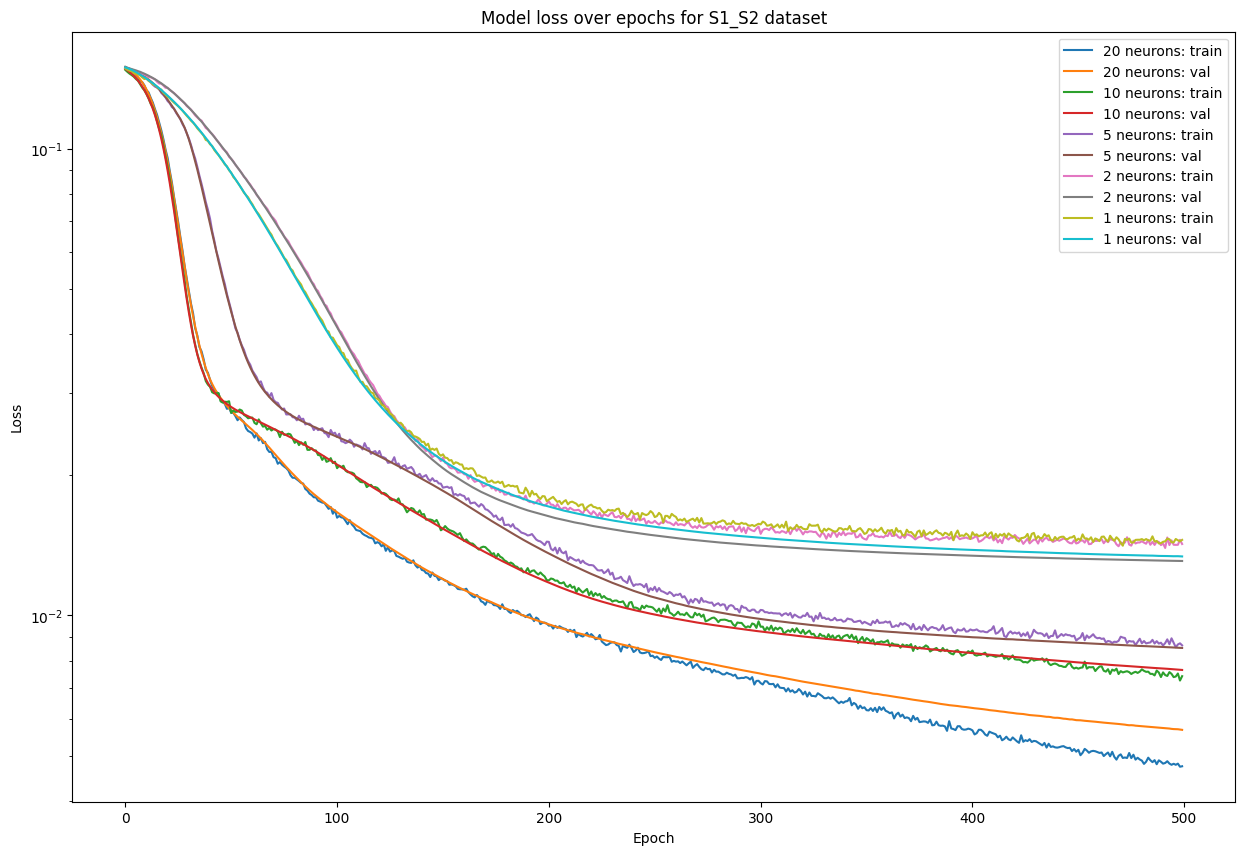

In [22]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense
from keras.models import Model

targets = ['status_strat']

for df_index, df in enumerate(data_frames):
    plt.figure(figsize=(15, 10))
    
    for l in [20, 10, 5, 2, 1]:
        target = 'status_strat'
        df_merged = pd.merge(df, file_to_case_df, on='file_id', how='left')
        df_merged = pd.merge(df_merged, clinical_df, on='case_submitter_id', how='left')
        df_final = df_merged.drop(columns=['file_id', 'case_submitter_id'])
        df1 = pd.concat([df_final.iloc[:, :-7], df_final[target]], axis=1).dropna()
        X = df1.iloc[:, :-1]
        y = df1.iloc[:, -1]
        X = MinMaxScaler().fit_transform(X)

        input_img = Input(shape=(X.shape[1],))
        encoded = Dense(X.shape[1], activation='relu')(input_img)
        encoded = Dense(l, activation='relu')(encoded) 
        decoded = Dense(X.shape[1], activation='sigmoid')(encoded)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer='adam', loss='mean_squared_error')

        history = autoencoder.fit(X, X, epochs=500, batch_size=256, validation_split=0.2, verbose=0)

        plt.plot(history.history['loss'], label=str(l) + ' neurons: train')
        plt.plot(history.history['val_loss'], label=str(l) + ' neurons: val')
    
    plt.title(f'Model loss over epochs for {data_frame_names[df_index]} dataset')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()


Here, we explore the use of autoencoders for dimensionality reduction, varying the number of neurons in the compressed layer. This allows us to examine the impact of compression on model loss over epochs.

### Evaluating Models Post-Compression

In [24]:
targets = ['status_strat']

for df_index, df in enumerate(data_frames):    
    df_merged = pd.merge(df, file_to_case_df, on='file_id', how='left')
    df_merged = pd.merge(df_merged, clinical_df, on='case_submitter_id', how='left')
    df_final = df_merged.drop(columns=['file_id', 'case_submitter_id'])
    
    for l in [20, 10, 5, 2, 1]:
        df1 = pd.concat([df_final.iloc[:, :-7], df_final[targets[0]]], axis=1).dropna()
        X = df1.iloc[:, :-1]
        y = df1.iloc[:, -1]
        X = MinMaxScaler().fit_transform(X)
        
        input_img = Input(shape=(X.shape[1],))
        encoded = Dense(l, activation='relu')(input_img)
        decoded = Dense(X.shape[1], activation='sigmoid')(encoded)

        autoencoder = Model(input_img, decoded)
        autoencoder.compile(optimizer='adam', loss='mean_squared_error')

        history = autoencoder.fit(X, X, epochs=500, batch_size=256, validation_split=0.2, verbose=0)
        
        encoder = Model(input_img, encoded)
        encoded_imgs = encoder.predict(X)
        
        X_encoded_scaled = MinMaxScaler().fit_transform(encoded_imgs)
        
        X_train, X_test, y_train, y_test = train_test_split(X_encoded_scaled, y, test_size=0.1, random_state=42)
        
        classifier = RandomForestClassifier(random_state=42)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        
        print(f"Data set: {data_frame_names[df_index]}, Neurons in compressed layer: {l}, F1 Score (micro): {f1_score(y_test, y_pred, average='micro')}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S1, Neurons in compressed layer: 20, F1 Score (micro): 0.5576923076923077
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S1, Neurons in compressed layer: 10, F1 Score (micro): 0.6346153846153846
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S1, Neurons in compressed layer: 5, F1 Score (micro): 0.4807692307692308
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S1, Neurons in compressed layer: 2, F1 Score (micro): 0.46153846153846156
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S1, Neurons in compressed layer: 1, F1 Score (micro): 0.6538461538461539
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S2, Neurons in compressed layer: 20, F1 Score (micro): 0.5769230769230769
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S2, Neurons in compressed layer: 10, F1 Score (micro): 0.5961538461538461
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Data set: S2, Neurons in compressed layer: 5, F1 Score (micro): 0.5769230769230769
17/17 ━━━━━

After compressing features using autoencoders, we assess the performance of RandomForestClassifiers on the compressed features. This section aims to evaluate the effectiveness of feature compression in improving classification performance.